In [1]:
%matplotlib inline

In [24]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple
from tqdm import tqdm_notebook as tqdm

# Rank model implementation
Based on https://mtgarena.community.gl/forums/threads/43384

In [3]:
ranks = {
    'B': {'W':2, 'L':0, 'S':4},
    'S': {'W':2, 'L':-1, 'S':5},
    'G': {'W':1, 'L':-1, 'S':6},
    'P': {'W':1, 'L':-1, 'S':7},
    'D': {'W':1, 'L':-1, 'S':7}
}
order_ranks = list(ranks.keys())
Rank = namedtuple('Rank', ['rank', 'tier', 'step', 'played', 'protection'])

In [4]:
def move(rank, winrate=0.5):
    if random.random() <= winrate:
        status = 'W'
    else:
        status = 'L'
    move = ranks[rank.rank][status]
    new_step = rank.step + move
    new_rank = rank.rank
    new_tier = rank.tier
    new_protection = False
    if new_step >= ranks[rank.rank]['S']: # We are above the required steps, so we go up.
        new_step = 0 
        new_protection = True # Protection when you go up in tier!
        if rank.tier == 1: # If we are in tier 1, we go up a rank
            if rank.rank == 'D': # in rank is D, we are MYTHIC!
                return Rank('M', 0, 0, rank.played + 1, False)
            new_rank = order_ranks[order_ranks.index(rank.rank) + 1]
            new_tier = 4
        else: # We don't go up in rank, only in tier
            new_tier = rank.tier - 1
    elif new_step < 0: # We lost, so maybe we go down in rank
        if rank.protection: # Nope since we have protection
            new_step = rank.step
        else: # If we are in tiers 1, 2 or 3 we go down one tier
            if rank.tier < 4:
                new_tier = rank.tier + 1
                new_step = ranks[rank.rank]['S'] - 1 # UNKNOWN: Don't know where you land, no info. This is a guess.
    r = Rank(new_rank, new_tier, new_step, rank.played + 1, new_protection)
    #print(status, r)
    return r

rank = Rank('B', 4, 0, 0, False)
print(rank)

Rank(rank='B', tier=4, step=0, played=0, protection=False)


# Example of a run from bronze to mythic

In [5]:
rank = Rank('B', 4, 0, 0, False)
for i in range(10000):
    rank = move(rank, winrate=0.7)
    print(rank)
    if rank.rank == 'M':
        break
rank

Rank(rank='B', tier=4, step=2, played=1, protection=False)
Rank(rank='B', tier=3, step=0, played=2, protection=True)
Rank(rank='B', tier=3, step=2, played=3, protection=False)
Rank(rank='B', tier=3, step=2, played=4, protection=False)
Rank(rank='B', tier=2, step=0, played=5, protection=True)
Rank(rank='B', tier=2, step=0, played=6, protection=False)
Rank(rank='B', tier=2, step=0, played=7, protection=False)
Rank(rank='B', tier=2, step=2, played=8, protection=False)
Rank(rank='B', tier=2, step=2, played=9, protection=False)
Rank(rank='B', tier=1, step=0, played=10, protection=True)
Rank(rank='B', tier=1, step=0, played=11, protection=False)
Rank(rank='B', tier=1, step=2, played=12, protection=False)
Rank(rank='S', tier=4, step=0, played=13, protection=True)
Rank(rank='S', tier=4, step=2, played=14, protection=False)
Rank(rank='S', tier=4, step=4, played=15, protection=False)
Rank(rank='S', tier=4, step=3, played=16, protection=False)
Rank(rank='S', tier=4, step=2, played=17, protection=

Rank(rank='M', tier=0, step=0, played=231, protection=False)

# Monte Carlo simulation

In [6]:
# It can be done with threads to a significant speedup, but this is only a proof of concept.
def simulation(trials=10, winrates=[0.5, 0.533, 0.566, 0.6, 0.633, 0.666, 0.7, 0.733, 0.766, 0.8], limit=30000):
    df = pd.DataFrame(index=list(range(10)), columns=winrates)
    for wr in winrates:
        for i in tqdm(range(int(trials)), desc='%.3f' % wr):
            rank = Rank('B', 4, 0, 0, False)
            for _ in range(int(limit)):
                rank = move(rank, winrate=wr)
                if rank.rank == 'M':
                    df.loc[i, wr] = rank.played
                    break
            else:
                df.loc[i, wr] = limit
    return df

In [7]:
df = simulation(trials=10000, limit=5e4)
df.columns = ['%.1f%%' % (c * 100) for c in df.columns]

In [8]:
df.head()

,50.0%,53.3%,56.6%,60.0%,63.3%,66.6%,70.0%,73.3%,76.6%,80.0%
0,1395,789,373,367,263,276,196,191,168,141
1,962,1567,531,316,198,206,257,219,156,152
2,50000,1040,557,539,264,206,185,134,180,170
3,7271,999,623,308,256,290,268,173,219,173
4,2514,960,587,499,346,268,186,162,185,165


# AVG Games to reach legend

In [12]:
aggs = df.agg([np.mean, np.std, np.median])
aggs.round(2)

,50.0%,53.3%,56.6%,60.0%,63.3%,66.6%,70.0%,73.3%,76.6%,80.0%
mean,14451.99,980.40,559.75,396.57,312.00,258.68,219.29,192.49,171.47,154.65
std,17693.72,399.68,148.01,85.25,56.47,40.72,30.19,23.62,18.63,14.62
median,5060.00,897.00,540.00,387.00,307.00,255.00,216.00,190.00,170.00,154.00


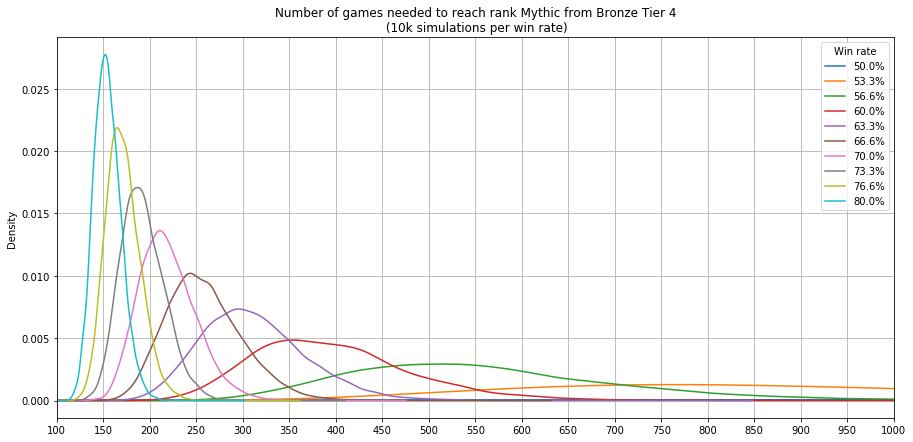

In [11]:
df.plot(kind='kde', figsize=(15, 7), xlim=(100, 1000), grid=True, 
        logx=False, xticks=[100 + 50 * x for x in range(20)],
        title='Number of games needed to reach rank Mythic from Bronze Tier 4\n (10k simulations per win rate)')
legend = plt.legend(title="Win rate", loc=1, fontsize='medium', fancybox=True)

# AVG Hours to reach Mythic
## 10 mins game

In [16]:
df_mins = df * 10 / 60
aggs = df_mins.agg([np.mean, np.std, np.median])
aggs.round(2)

,50.0%,53.3%,56.6%,60.0%,63.3%,66.6%,70.0%,73.3%,76.6%,80.0%
mean,2408.67,163.40,93.29,66.09,52.00,43.11,36.55,32.08,28.58,25.78
std,2948.95,66.61,24.67,14.21,9.41,6.79,5.03,3.94,3.10,2.44
median,843.33,149.50,90.00,64.50,51.17,42.50,36.00,31.67,28.33,25.67


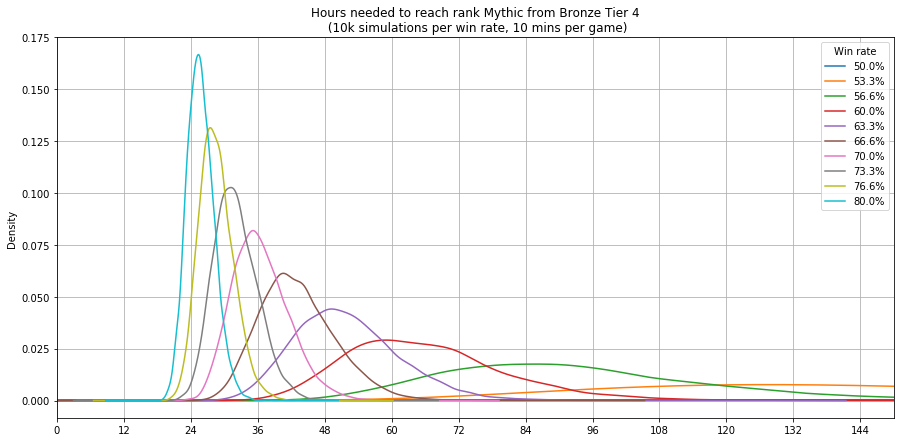

In [22]:
df_mins.plot(kind='kde', figsize=(15, 7), xlim=(0, 150), grid=True, 
        logx=False, xticks=[0 + 12 * x for x in range(20)],
        title='Hours needed to reach rank Mythic from Bronze Tier 4\n (10k simulations per win rate, 10 mins per game)')
legend = plt.legend(title="Win rate", loc=1, fontsize='medium', fancybox=True)